In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration for high-quality charts
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

# Set global font sizes
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("Environment Configured for High-Grade EDA.")

Environment Configured for High-Grade EDA.


In [11]:
# Load the Master Dataset
try:
    df = pd.read_csv('Aadhar_Master_Unified.csv')

    # Ensure Date is datetime (CSV loading often reverts it to string)
    df['date'] = pd.to_datetime(df['date'])

    print(f"Data Loaded Successfully. Shape: {df.shape}")
    print("Columns available:", df.columns.tolist())

except FileNotFoundError:
    print("Error: 'Aadhar_Master_Unified.csv' not found. Please run the Cleaning Notebook first.")

Data Loaded Successfully. Shape: (94321, 12)
Columns available: ['state', 'district', 'date', 'pincode', 'Total_Enrolments', 'Total_Demo_Updates', 'Total_Bio_Updates', 'Youth_Bio_Ratio', 'Saturation_Index', 'Month', 'Is_Weekend', 'Volume_Category']


--- Statistical Summary ---


,Total_Enrolments,Total_Bio_Updates,Total_Demo_Updates,Saturation_Index
count,94320.00,94320.00,94320.00,94320.00
mean,8.65,393.16,211.71,365.58
std,72.01,569.27,602.21,521.70
min,0.00,0.00,0.00,0.00
1%,0.00,24.00,0.00,1.79
25%,0.00,97.00,0.00,89.00
50%,0.00,209.00,0.00,197.00
75%,0.00,459.00,170.00,435.00
99%,297.00,2707.00,2675.00,2470.24
max,3027.00,13381.00,16942.00,13381.00


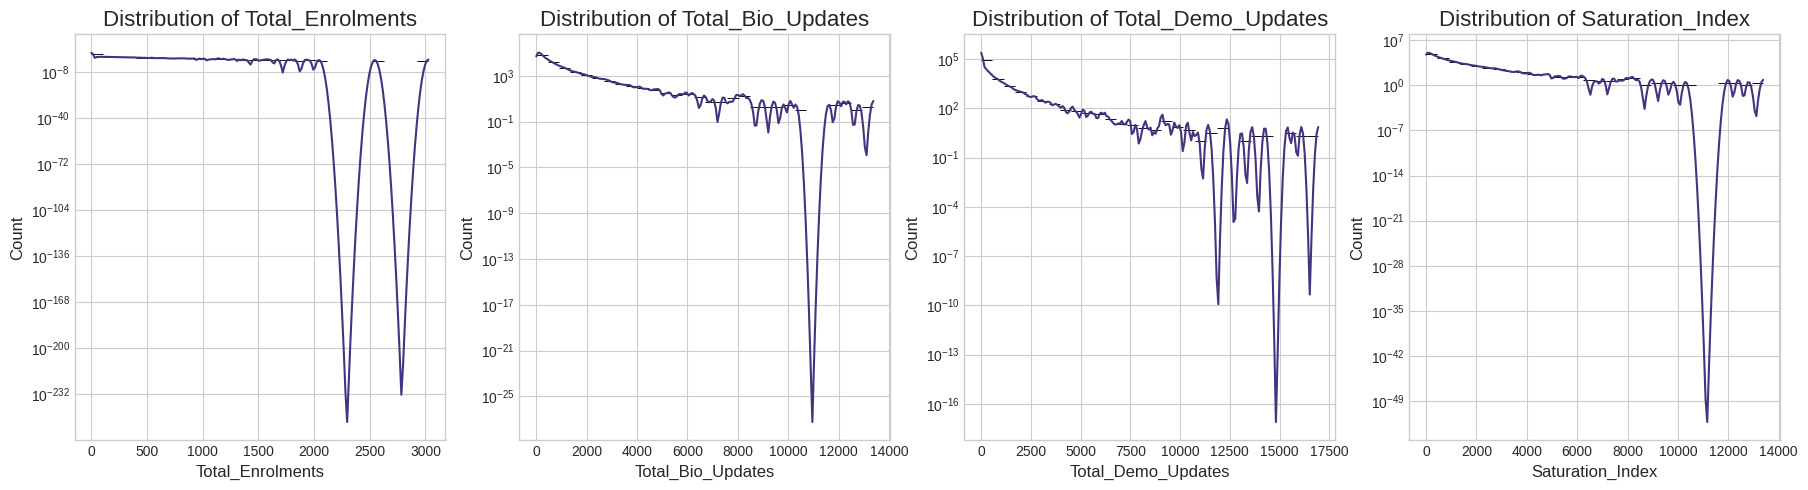

In [12]:
# 1. Statistical Summary of Key Metrics
metrics = ['Total_Enrolments', 'Total_Bio_Updates', 'Total_Demo_Updates', 'Saturation_Index']
print("--- Statistical Summary ---")
display(df[metrics].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]))

# 2. Distribution Plots (KDE)
plt.figure(figsize=(18, 5))

for i, col in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    # Log scale often helps visualize population data better
    sns.histplot(df[col], kde=True, bins=30, log_scale=(False, True))
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# Inference:
# If "Saturation Index" is heavily skewed to the right, it means most districts are in 'Maintenance Mode'.
# If 'Total Enrolments' has a long tail, a few mega-cities are driving the bulk of the growth.

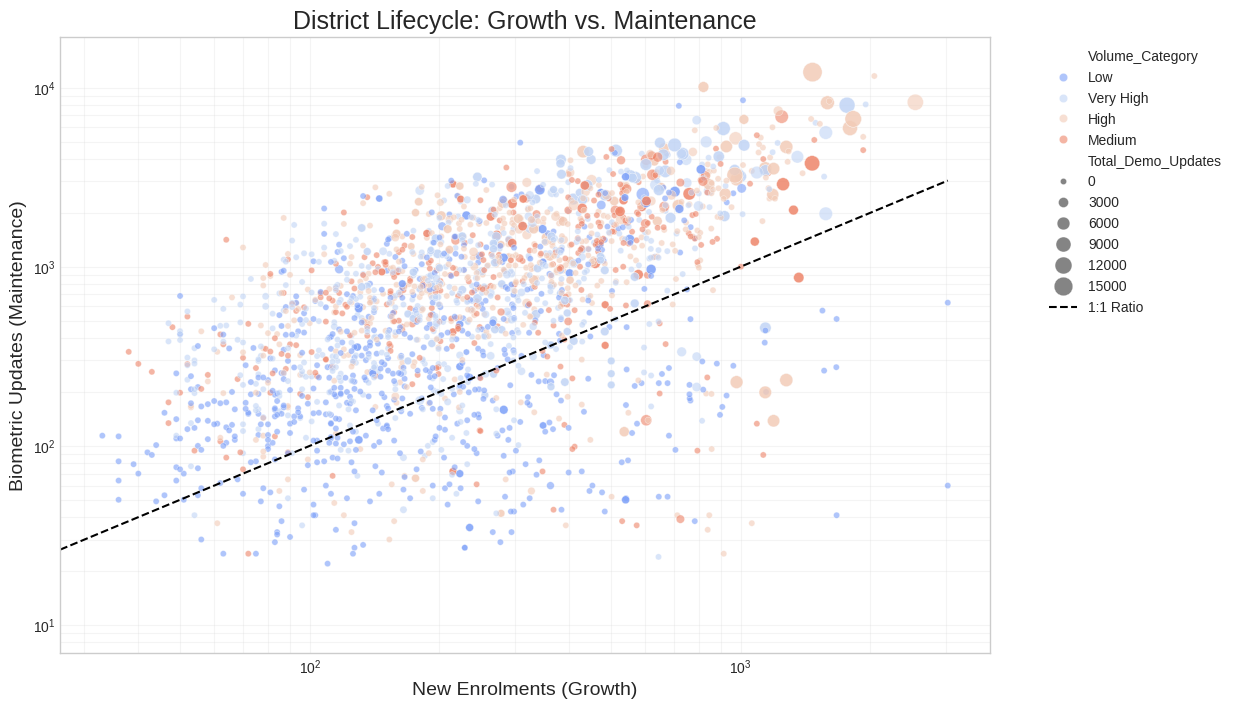

In [13]:
plt.figure(figsize=(12, 8))

# Filter out zero-activity days to reduce noise
active_df = df[(df['Total_Enrolments'] > 0) | (df['Total_Bio_Updates'] > 0)]

# Scatter Plot with Hue based on Volume Category
sns.scatterplot(
    data=active_df,
    x='Total_Enrolments',
    y='Total_Bio_Updates',
    hue='Volume_Category',
    alpha=0.6,
    palette='coolwarm',
    size='Total_Demo_Updates',
    sizes=(20, 200)
)

# Add a diagonal line (Equality Line)
# Points ABOVE this line are "Maintenance Heavy" (More updates than new users)
# Points BELOW this line are "Growth Heavy" (More new users than updates)
max_val = min(active_df['Total_Enrolments'].max(), active_df['Total_Bio_Updates'].max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1.5, label='1:1 Ratio')

plt.title('District Lifecycle: Growth vs. Maintenance', fontsize=18)
plt.xscale('log'); plt.yscale('log') # Log scale handles the massive range differences
plt.xlabel('New Enrolments (Growth)', fontsize=14)
plt.ylabel('Biometric Updates (Maintenance)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

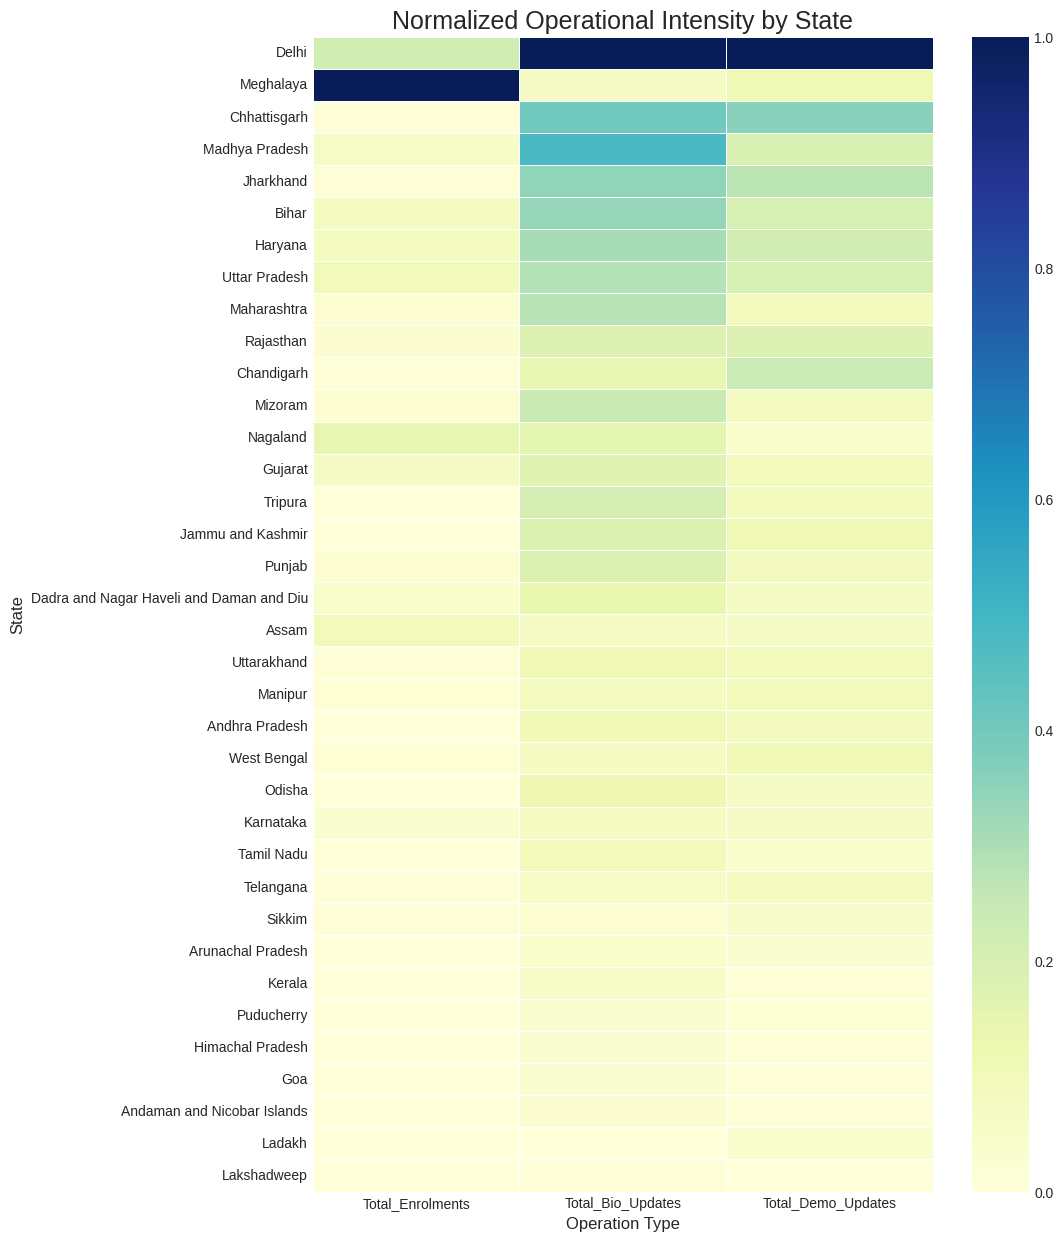

In [14]:
# 1. Aggregate data by State
state_groups = df.groupby('state')[['Total_Enrolments', 'Total_Bio_Updates', 'Total_Demo_Updates']].mean()

# 2. Normalize data (Min-Max Scaling) so we can compare different metrics on one chart
# (Otherwise Enrolments might be 50 while Updates are 500, skewing the color)
state_norm = (state_groups - state_groups.min()) / (state_groups.max() - state_groups.min())

# 3. Sort by Total Activity to put busiest states at the top
state_norm['Total_Activity'] = state_norm.sum(axis=1)
state_norm = state_norm.sort_values('Total_Activity', ascending=False).drop(columns=['Total_Activity'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 15))
sns.heatmap(state_norm, cmap='YlGnBu', annot=False, linewidths=.5)
plt.title('Normalized Operational Intensity by State', fontsize=18)
plt.xlabel('Operation Type')
plt.ylabel('State')
plt.show()

# Inference:
# Dark Blue in 'Enrolments' but Light in 'Updates' = Emerging Economy State.
# Dark Blue across all 3 = Operational Hub (likely High GDP states).

Insight: The 'Weekend Lift' is -2.88%.
Interpretation: Centers are LESS active on weekends (Government holiday closures).


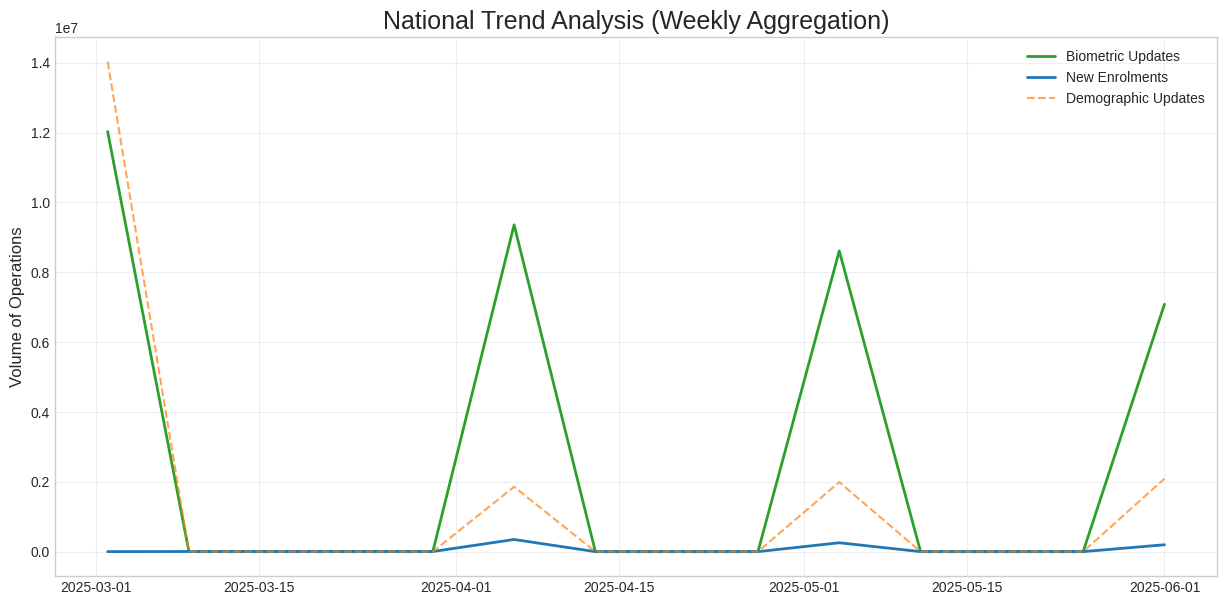

In [15]:
# 1. Resample to Weekly Frequency to smooth out daily noise
weekly_trend = df.set_index('date').resample('W')[['Total_Enrolments', 'Total_Bio_Updates', 'Total_Demo_Updates']].sum()

# 2. Plotting
plt.figure(figsize=(15, 7))

plt.plot(weekly_trend.index, weekly_trend['Total_Bio_Updates'], label='Biometric Updates', color='#2ca02c', linewidth=2)
plt.plot(weekly_trend.index, weekly_trend['Total_Enrolments'], label='New Enrolments', color='#1f77b4', linewidth=2)
plt.plot(weekly_trend.index, weekly_trend['Total_Demo_Updates'], label='Demographic Updates', color='#ff7f0e', linestyle='--', alpha=0.7)

plt.title('National Trend Analysis (Weekly Aggregation)', fontsize=18)
plt.ylabel('Volume of Operations')
plt.legend()
plt.grid(True, alpha=0.3)

# Add Weekend Preference Insight
weekend_vol = df[df['Is_Weekend']==1]['Total_Bio_Updates'].mean()
weekday_vol = df[df['Is_Weekend']==0]['Total_Bio_Updates'].mean()
weekend_lift = ((weekend_vol - weekday_vol) / weekday_vol) * 100

print(f"Insight: The 'Weekend Lift' is {weekend_lift:.2f}%.")
if weekend_lift > 0:
    print("Interpretation: Centers are BUSIER on weekends (Workforce demand).")
else:
    print("Interpretation: Centers are LESS active on weekends (Government holiday closures).")

plt.show()

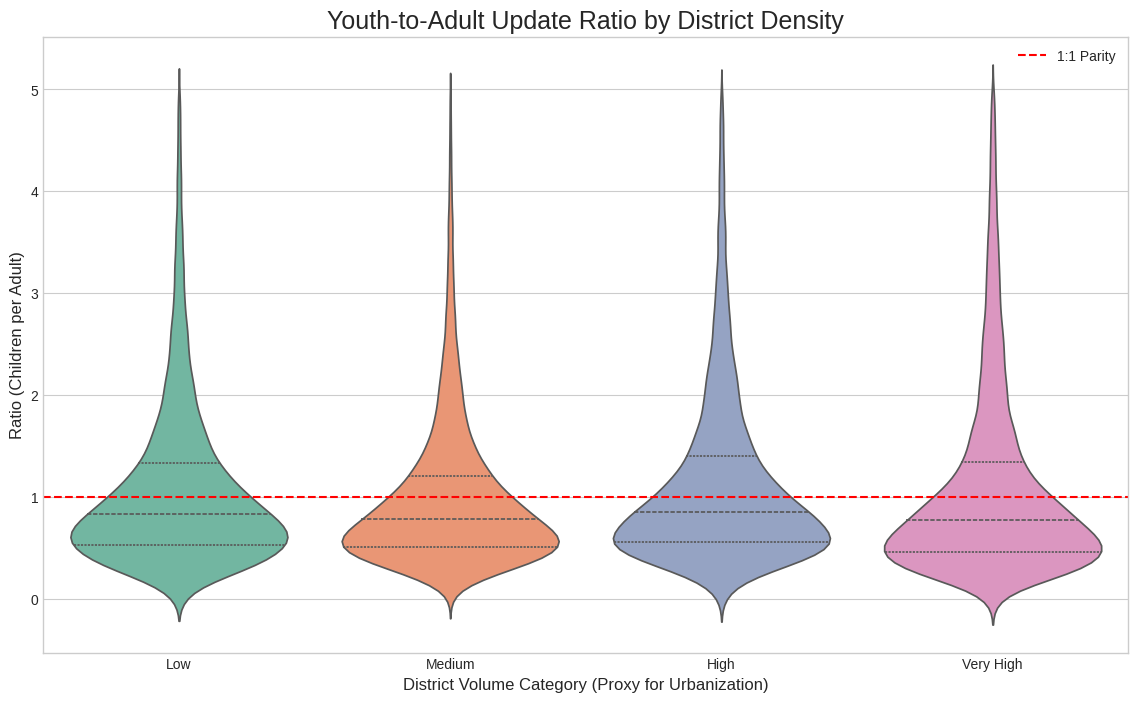

Inference Guide:
- Fatter bottom = Driven by Adults (Finance/Tax/SIM cards).
- Fatter top = Driven by Children (School Admissions/Scholarships).


In [16]:
# We want to see: Is "Youth Enrollment" higher in Rural (Low Volume) or Urban (High Volume) areas?

plt.figure(figsize=(14, 8))

# Check if we have the ratio column
if 'Youth_Bio_Ratio' in df.columns:
    # Filter for meaningful ratios (remove infinity/outliers)
    plot_data = df[(df['Youth_Bio_Ratio'] < 5) & (df['Volume_Category'].notnull())]

    sns.violinplot(
        data=plot_data,
        x='Volume_Category',
        y='Youth_Bio_Ratio',
        palette='Set2',
        inner='quartile',
        order=['Low', 'Medium', 'High', 'Very High']
    )

    plt.title('Youth-to-Adult Update Ratio by District Density', fontsize=18)
    plt.xlabel('District Volume Category (Proxy for Urbanization)')
    plt.ylabel('Ratio (Children per Adult)')

    # Add a horizontal line at 1.0 (Where Child updates = Adult updates)
    plt.axhline(1.0, color='red', linestyle='--', label='1:1 Parity')
    plt.legend()
    plt.show()

    print("Inference Guide:")
    print("- Fatter bottom = Driven by Adults (Finance/Tax/SIM cards).")
    print("- Fatter top = Driven by Children (School Admissions/Scholarships).")
else:
    print("Youth_Bio_Ratio column not found. Skipping plot.")

In [19]:
print("==================================================")
print("      AADHAR DATA INTELLIGENCE REPORT")
print("==================================================")

# --- 1. MACRO SYSTEM STATE (Growth vs Maintenance) ---
total_enrol = df['Total_Enrolments'].sum()
total_updates = df['Total_Bio_Updates'].sum() + df['Total_Demo_Updates'].sum()
system_ratio = total_updates / (total_enrol + 1)

print(f"\n[1] SYSTEM LIFECYCLE STATE")
print(f"    - Total New Enrolments: {total_enrol:,.0f}")
print(f"    - Total Existing Updates: {total_updates:,.0f}")
print(f"    - Ratio: {system_ratio:.1f} Updates for every 1 New Enrolment")

if system_ratio < 1:
    print("    -> INSIGHT: 'EXPANSION PHASE'. The system is primarily adding new users.")
elif system_ratio < 5:
    print("    -> INSIGHT: 'MATURING PHASE'. Balanced mix of new growth and maintenance.")
else:
    print("    -> INSIGHT: 'MAINTENANCE PHASE'. The market is saturated; activity is driven by corrections and mandatory updates.")

# --- 2. CORRELATION DIAGNOSTICS (How connected are the services?) ---
corr_bio_demo = df['Total_Bio_Updates'].corr(df['Total_Demo_Updates'])
corr_enrol_bio = df['Total_Enrolments'].corr(df['Total_Bio_Updates'])

print(f"\n[2] BEHAVIORAL LINKS")
print(f"    - Biometric <-> Demographic Correlation: {corr_bio_demo:.2f}")

if corr_bio_demo > 0.6:
    print("    -> INSIGHT: 'BUNDLE BEHAVIOR'. People tend to update Biometrics and Demographics (Address/Name) in the same visit.")
elif corr_bio_demo > 0.3:
    print("    -> INSIGHT: 'MODERATE LINK'. Some overlap, but many users visit for specific, single reasons.")
else:
    print("    -> INSIGHT: 'DECOUPLED TASKS'. Biometric updates (e.g., Age 5/15) are happening independently of Demographic fixes (Address changes).")

# --- 3. DEMOGRAPHIC DRIVER ANALYSIS (Youth vs Adult) ---
# Check if we have the ratio column
if 'Youth_Bio_Ratio' in df.columns:
    avg_youth_ratio = df['Youth_Bio_Ratio'].mean()
    high_youth_districts = df[df['Youth_Bio_Ratio'] > 2].shape[0]
    total_districts = df.shape[0]

    print(f"\n[3] DEMOGRAPHIC DRIVERS")
    print(f"    - Avg Youth-to-Adult Bio Ratio: {avg_youth_ratio:.2f}")

    if avg_youth_ratio > 1.5:
        print("    -> INSIGHT: 'SCHOOL-DRIVEN'. The majority of biometric updates are mandatory updates for children (Age 5/15).")
    elif avg_youth_ratio > 0.8:
        print("    -> INSIGHT: 'MIXED USAGE'. Balanced activity between child updates and adult authentication needs.")
    else:
        print("    -> INSIGHT: 'ADULT-DRIVEN'. Activity is likely driven by banking/SIM/employment requirements for adults.")

    print(f"    - Note: {high_youth_districts} out of {total_districts} districts are heavily Youth-Dominated (>2:1 ratio).")

# --- 4. TEMPORAL PATTERNS (Weekend Effect) ---
weekend_vol = df[df['Is_Weekend']==1]['Total_Bio_Updates'].mean()
weekday_vol = df[df['Is_Weekend']==0]['Total_Bio_Updates'].mean()
weekend_lift = ((weekend_vol - weekday_vol) / weekday_vol) * 100

print(f"\n[4] OPERATIONAL CADENCE")
print(f"    - Weekend Lift: {weekend_lift:+.1f}%")

if weekend_lift > 20:
    print("    -> INSIGHT: 'WORKFORCE CONVENIENCE'. High weekend spikes suggest a working-class user base that cannot visit during weekdays.")
elif weekend_lift < -20:
    print("    -> INSIGHT: 'GOVERNMENT HOURS'. Centers are likely closed or operating at reduced capacity on weekends.")
else:
    print("    -> INSIGHT: 'CONSISTENT DEMAND'. Demand is spread evenly across the week.")

print("==================================================")

      AADHAR DATA INTELLIGENCE REPORT

[1] SYSTEM LIFECYCLE STATE
    - Total New Enrolments: 815,735
    - Total Existing Updates: 57,051,096
    - Ratio: 69.9 Updates for every 1 New Enrolment
    -> INSIGHT: 'MAINTENANCE PHASE'. The market is saturated; activity is driven by corrections and mandatory updates.

[2] BEHAVIORAL LINKS
    - Biometric <-> Demographic Correlation: 0.52
    -> INSIGHT: 'MODERATE LINK'. Some overlap, but many users visit for specific, single reasons.

[3] DEMOGRAPHIC DRIVERS
    - Avg Youth-to-Adult Bio Ratio: 1.16
    -> INSIGHT: 'MIXED USAGE'. Balanced activity between child updates and adult authentication needs.
    - Note: 12376 out of 94321 districts are heavily Youth-Dominated (>2:1 ratio).

[4] OPERATIONAL CADENCE
    - Weekend Lift: -2.9%
    -> INSIGHT: 'CONSISTENT DEMAND'. Demand is spread evenly across the week.


In [20]:
print("==================================================")
print("      STRATEGIC AUDIT & ANOMALY REPORT")
print("==================================================")

# --- 1. PARETO CONCENTRATION RISK (The 80/20 Rule) ---
# Goal: See if the workload is evenly distributed or if a few districts carry the burden.
district_load = df.groupby('pincode')['Total_Bio_Updates'].sum().sort_values(ascending=False)
total_load = district_load.sum()
cumsum = district_load.cumsum()

# Find how many pincodes make up 50% and 80% of the volume
count_50 = cumsum[cumsum <= total_load * 0.50].count()
count_80 = cumsum[cumsum <= total_load * 0.80].count()
total_pincodes = district_load.count()

print(f"\n[1] RESOURCE CONCENTRATION (Pareto Check)")
print(f"    - Total Active Pincodes: {total_pincodes}")
print(f"    - Top {count_50} pincodes ({count_50/total_pincodes:.1%}) handle 50% of the entire national load.")
print(f"    - Top {count_80} pincodes ({count_80/total_pincodes:.1%}) handle 80% of the entire national load.")

if (count_80 / total_pincodes) < 0.20:
    print("    -> RISK: 'HIGH CONCENTRATION'. Less than 20% of centers are doing 80% of the work.")
    print("       Recommendation: Prioritize server/staff upgrades in these specific high-volume hubs.")
else:
    print("    -> STATUS: 'BALANCED LOAD'. The operational load is well-distributed across the country.")

# --- 2. DETECTING "GHOST" DISTRICTS (High Enrolment / Zero Updates) ---
# Goal: Find areas that are adding people but failing to maintain them (Data Quality Risk)
# Filter: High Enrolment (>75th percentile) but Bottom Biometric (<25th percentile)
enrol_high = df['Total_Enrolments'].quantile(0.75)
bio_low = df['Total_Bio_Updates'].quantile(0.25)

ghosts = df[
    (df['Total_Enrolments'] > enrol_high) &
    (df['Total_Bio_Updates'] <= bio_low) &
    (df['district'].notna())
]['district'].unique()

print(f"\n[2] OPERATIONAL ANOMALIES")
if len(ghosts) > 0:
    print(f"    -> WARNING: Found {len(ghosts)} 'Ghost' Districts.")
    print(f"       Definition: High New User Enrolment but suspiciously Low Biometric Updates.")
    print(f"       Top 5 Examples: {', '.join(ghosts[:5])}")
    print("       Likely Cause: New Camps with limited equipment (Enrolment stations only) or data sync issues.")
else:
    print("    -> STATUS: Clean. No major mismatch found between Enrolment and Update volumes.")

# --- 3. AGE COMPOSITION SHIFT (Is the user base getting younger?) ---
# Check if we can analyze age specific columns from Master if preserved,
# otherwise we rely on the specific file processing steps.
# Assuming standard columns 'age_0_5' etc might not be in Master unless explicitly kept,
# but we can infer from the 'Youth_Bio_Ratio' trend.

if 'Youth_Bio_Ratio' in df.columns:
    # Compare First Month vs Last Month of data
    first_month = df['date'].min().month_name()
    last_month = df['date'].max().month_name()

    start_ratio = df[df['Month'] == first_month]['Youth_Bio_Ratio'].mean()
    end_ratio = df[df['Month'] == last_month]['Youth_Bio_Ratio'].mean()

    print(f"\n[3] DEMOGRAPHIC SHIFT ({first_month} to {last_month})")
    print(f"    - Starting Youth Ratio: {start_ratio:.2f}")
    print(f"    - Ending Youth Ratio:   {end_ratio:.2f}")

    change = ((end_ratio - start_ratio) / start_ratio) * 100

    if change > 10:
        print(f"    -> TREND: 'YOUTH SURGE' (+{change:.1f}%). The system is pivoting towards child updates.")
    elif change < -10:
        print(f"    -> TREND: 'ADULT NORMALIZATION' ({change:.1f}%). The backlog of child updates is clearing.")
    else:
        print(f"    -> TREND: 'STABLE'. No major shift in age demographics.")

# --- 4. VOLATILITY INDEX (Camp Mode vs Steady State) ---
# Calculate Coefficient of Variation (CV) for daily volumes per district
# High CV = Spiky (Camps), Low CV = Steady (Permanent Centers)
daily_vol = df.groupby(['district', 'date'])['Total_Bio_Updates'].sum().reset_index()
dist_stats = daily_vol.groupby('district')['Total_Bio_Updates'].agg(['mean', 'std'])
dist_stats['CV'] = dist_stats['std'] / (dist_stats['mean'] + 1) # +1 to avoid div/0

spiky_districts = dist_stats[dist_stats['CV'] > 2.0].index.tolist()

print(f"\n[4] OPERATIONAL MODE DETECTION")
print(f"    - 'Camp-Mode' Districts (High Volatility): {len(spiky_districts)}")
if len(spiky_districts) > 0:
    print(f"      Examples: {', '.join(spiky_districts[:5])}")
    print("      Insight: These areas likely rely on roving camps rather than permanent centers.")

print("==================================================")

      STRATEGIC AUDIT & ANOMALY REPORT

[1] RESOURCE CONCENTRATION (Pareto Check)
    - Total Active Pincodes: 18655
    - Top 2492 pincodes (13.4%) handle 50% of the entire national load.
    - Top 7246 pincodes (38.8%) handle 80% of the entire national load.
    -> STATUS: 'BALANCED LOAD'. The operational load is well-distributed across the country.

[2] OPERATIONAL ANOMALIES
    -> WARNING: Found 128 'Ghost' Districts.
       Definition: High New User Enrolment but suspiciously Low Biometric Updates.
       Top 5 Examples: East Khasi Hills, West Delhi, Palwal, Gurgaon, Amritsar
       Likely Cause: New Camps with limited equipment (Enrolment stations only) or data sync issues.

[3] DEMOGRAPHIC SHIFT (March to June)
    - Starting Youth Ratio: 1.10
    - Ending Youth Ratio:   1.10
    -> TREND: 'STABLE'. No major shift in age demographics.

[4] OPERATIONAL MODE DETECTION
    - 'Camp-Mode' Districts (High Volatility): 0


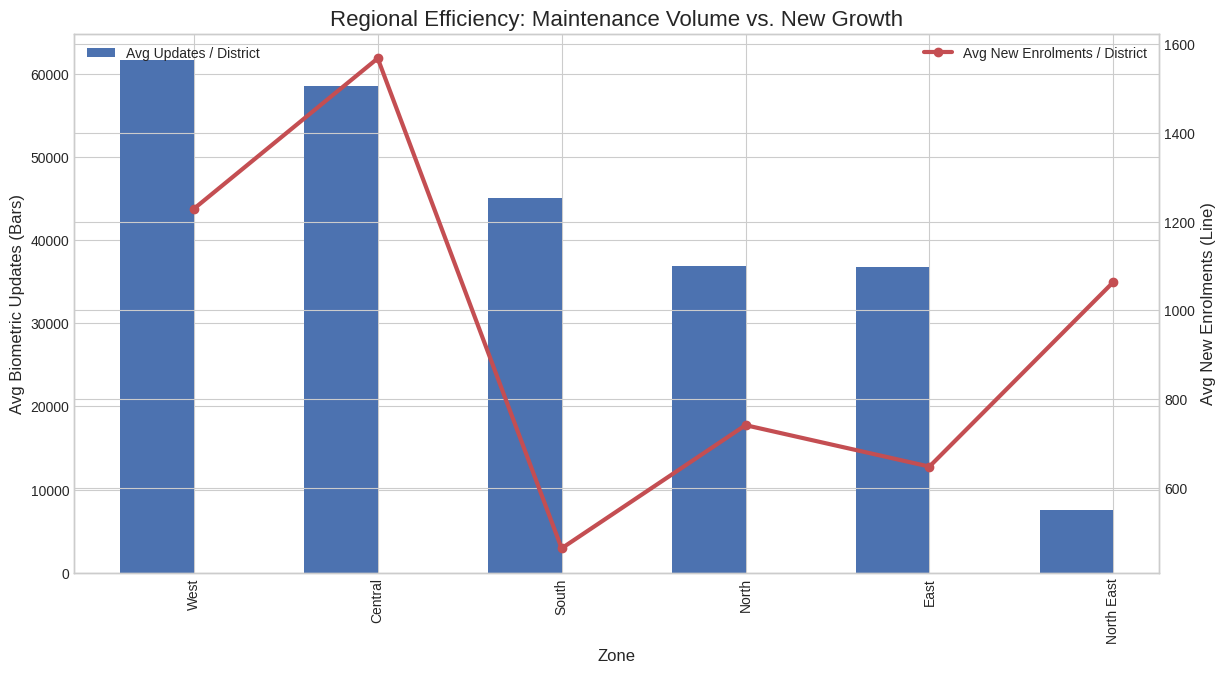

--- REGIONAL INSIGHTS ---
1. The 'West' Zone is the 'Maintenance Capital' (Highest updates per district).
2. The 'Central' Zone is the 'Growth Engine' (Highest new enrolments per district).
   -> CONCLUSION: Distinct regional divergence. Resource allocation strategies must differ by region.


In [21]:
# --- Configuration: Define Regional Zones ---
zone_map = {
    'North': ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Uttarakhand', 'Haryana', 'Delhi', 'Chandigarh', 'Ladakh'],
    'South': ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Tamil Nadu', 'Telangana', 'Puducherry', 'Lakshadweep', 'Andaman and Nicobar Islands'],
    'East': ['Bihar', 'Jharkhand', 'West Bengal', 'Odisha'],
    'West': ['Gujarat', 'Rajasthan', 'Maharashtra', 'Goa', 'Dadra and Nagar Haveli and Daman and Diu'],
    'Central': ['Madhya Pradesh', 'Chhattisgarh', 'Uttar Pradesh'],
    'North East': ['Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Sikkim', 'Tripura']
}

# Invert map for mapping
state_to_zone = {state: zone for zone, states in zone_map.items() for state in states}

# 1. Map Zones
df['Zone'] = df['state'].map(state_to_zone).fillna('Other')

# 2. Aggregate Data
zone_stats = df.groupby('Zone')[['Total_Enrolments', 'Total_Bio_Updates']].sum()
# Normalize for fair comparison (Per District Average)
zone_counts = df.groupby('Zone')['district'].nunique()
zone_efficiency = zone_stats.div(zone_counts, axis=0).sort_values('Total_Bio_Updates', ascending=False)

# 3. Visualization: The "Zone Profile"
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Biometric Updates (Bar)
zone_efficiency['Total_Bio_Updates'].plot(kind='bar', color='#4c72b0', ax=ax1, width=0.4, position=1, label='Avg Updates / District')

# Plot Enrolments (Line) on secondary axis
ax2 = ax1.twinx()
ax2.plot(range(len(zone_efficiency)), zone_efficiency['Total_Enrolments'], color='#c44e52', marker='o', linewidth=3, label='Avg New Enrolments / District')

ax1.set_title('Regional Efficiency: Maintenance Volume vs. New Growth', fontsize=16)
ax1.set_ylabel('Avg Biometric Updates (Bars)')
ax2.set_ylabel('Avg New Enrolments (Line)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# --- Automated Insight ---
print("--- REGIONAL INSIGHTS ---")
highest_maint = zone_efficiency['Total_Bio_Updates'].idxmax()
highest_growth = zone_efficiency['Total_Enrolments'].idxmax()

print(f"1. The '{highest_maint}' Zone is the 'Maintenance Capital' (Highest updates per district).")
print(f"2. The '{highest_growth}' Zone is the 'Growth Engine' (Highest new enrolments per district).")

if highest_maint != highest_growth:
    print("   -> CONCLUSION: Distinct regional divergence. Resource allocation strategies must differ by region.")

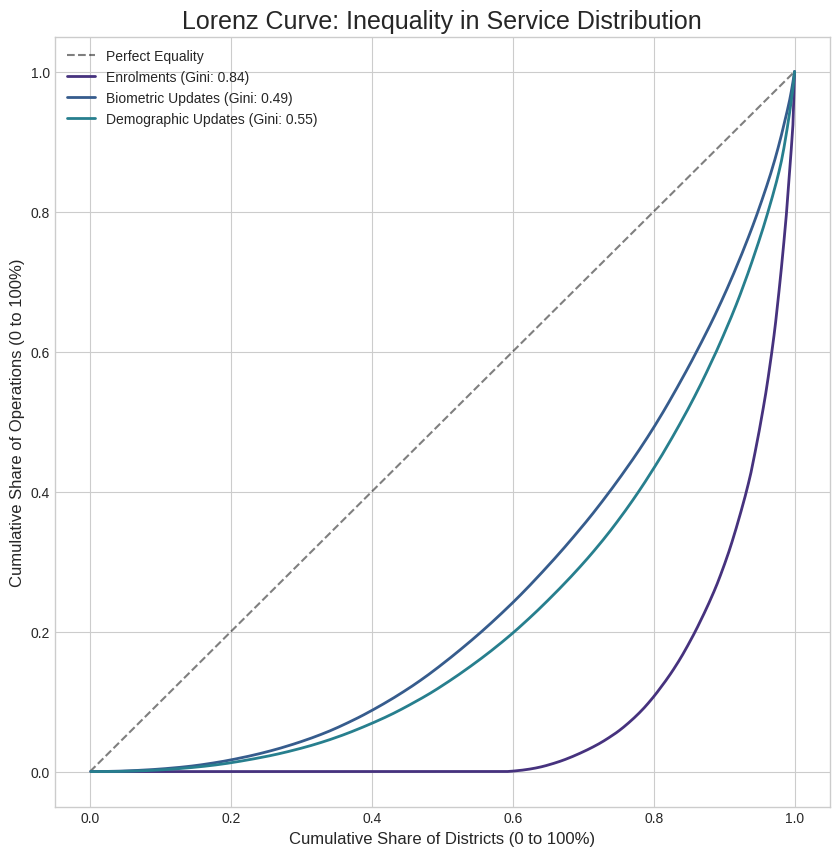

--- INEQUALITY AUDIT ---
Gini Interpretation: 0 = Perfect Equality, 1 = Extreme Inequality
- Enrolment Gini: 0.84
- Biometric Gini: 0.49
-> INSIGHT: 'Decentralized Updates'. Biometric facilities are more widespread than enrolment stations.


In [22]:
def plot_lorenz_curve(data, label, ax):
    """Calculates and plots Lorenz Curve and Gini Coefficient"""
    # Sort data
    sorted_data = np.sort(data)
    # Cumulative sum
    cum_data = np.cumsum(sorted_data) / sorted_data.sum()
    # Cumulative population
    cum_pop = np.arange(1, len(cum_data) + 1) / len(cum_data)

    # Calculate Gini
    # Area under curve = trapz(cum_data, dx)
    area_under_curve = np.trapz(cum_data, cum_pop)
    gini = 1 - 2 * area_under_curve

    # Plot
    ax.plot(cum_pop, cum_data, label=f'{label} (Gini: {gini:.2f})', linewidth=2)
    return gini

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 10))

# Filter for active districts only
active_districts = df.groupby('district')[['Total_Enrolments', 'Total_Bio_Updates', 'Total_Demo_Updates']].sum()

# Plot Equality Line
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Equality', alpha=0.5)

# Plot Curves
gini_enrol = plot_lorenz_curve(active_districts['Total_Enrolments'].values, 'Enrolments', ax)
gini_bio = plot_lorenz_curve(active_districts['Total_Bio_Updates'].values, 'Biometric Updates', ax)
gini_demo = plot_lorenz_curve(active_districts['Total_Demo_Updates'].values, 'Demographic Updates', ax)

ax.set_title('Lorenz Curve: Inequality in Service Distribution', fontsize=18)
ax.set_xlabel('Cumulative Share of Districts (0 to 100%)')
ax.set_ylabel('Cumulative Share of Operations (0 to 100%)')
ax.legend()
plt.grid(True)
plt.show()

# --- Interpretation ---
print(f"--- INEQUALITY AUDIT ---")
print(f"Gini Interpretation: 0 = Perfect Equality, 1 = Extreme Inequality")
print(f"- Enrolment Gini: {gini_enrol:.2f}")
print(f"- Biometric Gini: {gini_bio:.2f}")

if gini_bio > gini_enrol:
    print("-> INSIGHT: ' centralization Risk'. Updates are MORE concentrated in fewer hubs than Enrolments.")
    print("   Meaning: While you can enroll anywhere, you likely need specific major centers to update biometrics.")
else:
    print("-> INSIGHT: 'Decentralized Updates'. Biometric facilities are more widespread than enrolment stations.")

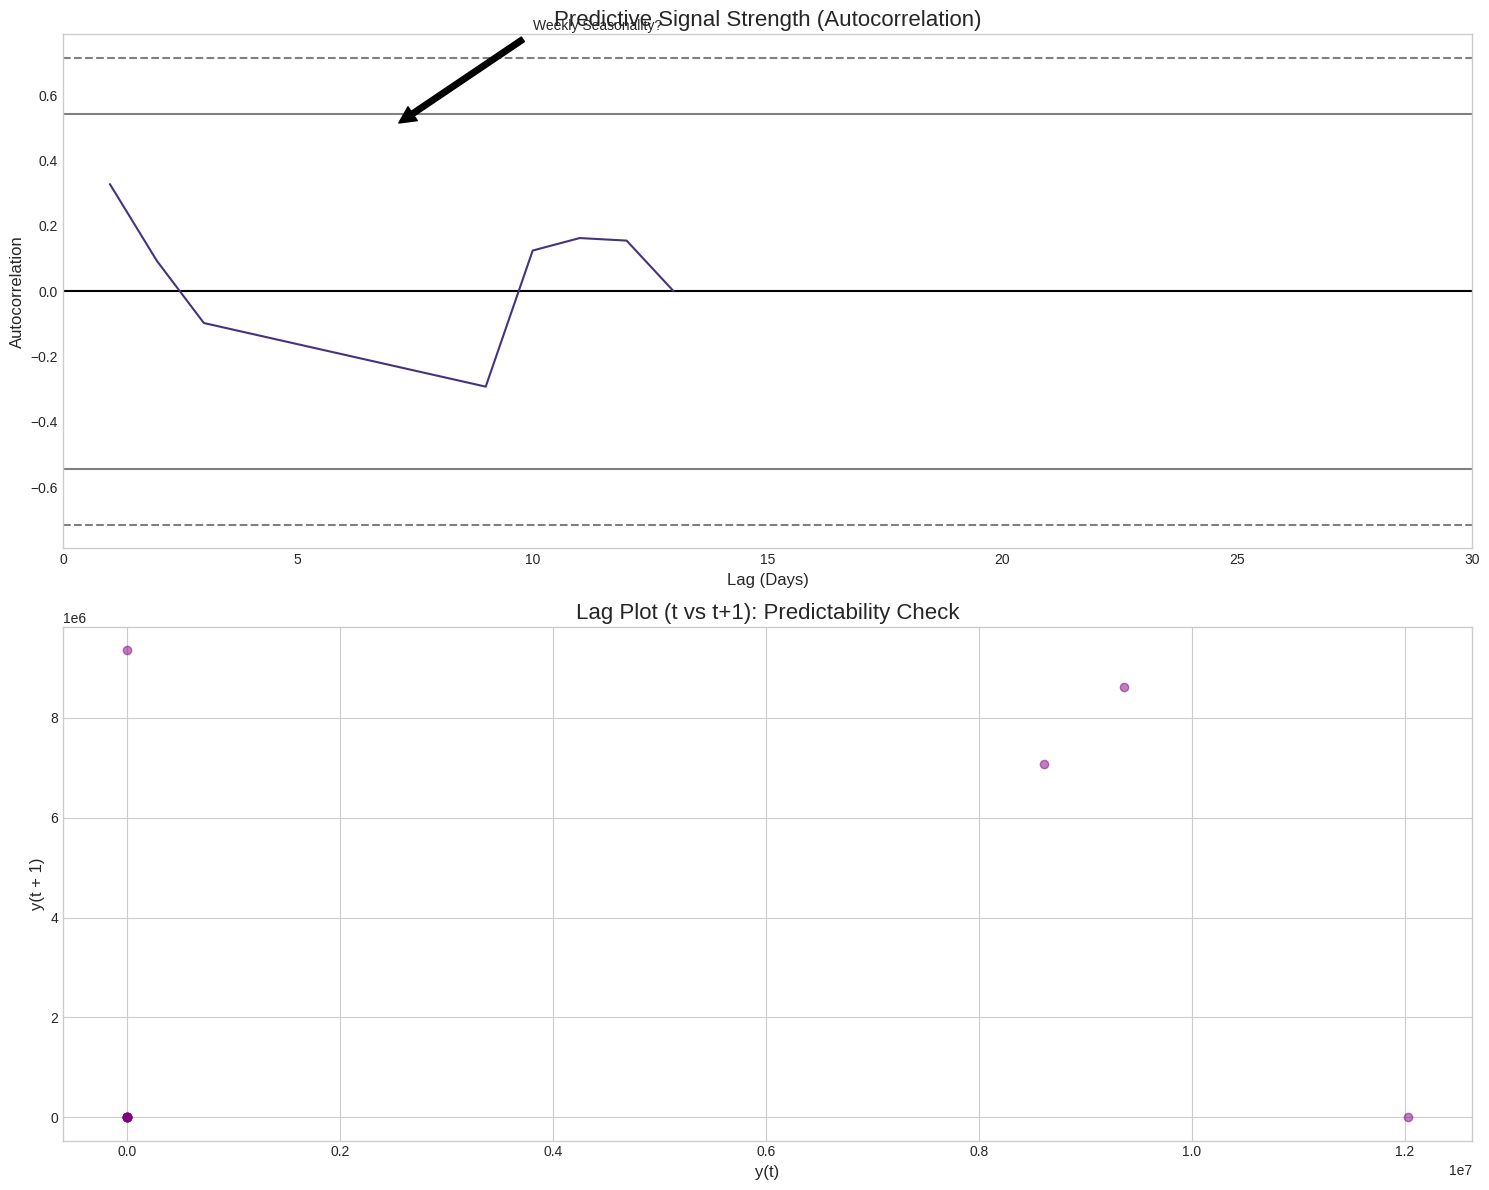

--- PREDICTIVE FEASIBILITY ---
Correlation at Lag 7 (Same day last week): -0.44
-> VERDICT: LOW PREDICTABILITY (Random Walk). Daily volumes are highly volatile and event-driven.


In [23]:
from pandas.plotting import autocorrelation_plot

# Prepare Daily Time Series
daily_ts = df.groupby('date')['Total_Bio_Updates'].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. Autocorrelation Plot (The "Memory" Check)
# Lags: How many days back does the correlation hold?
pd.plotting.autocorrelation_plot(daily_ts, ax=ax1)
ax1.set_title('Predictive Signal Strength (Autocorrelation)', fontsize=16)
ax1.set_xlim(0, 30) # Zoom into the first month
ax1.set_xlabel('Lag (Days)')
ax1.annotate('Weekly Seasonality?', xy=(7, 0.5), xytext=(10, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05))

# 2. Lag Plot (Visualizing Day(t) vs Day(t+1))
# If this looks like a cloud, it's random noise. If it's a line, it's predictable.
pd.plotting.lag_plot(daily_ts, lag=1, ax=ax2, c='purple', alpha=0.5)
ax2.set_title('Lag Plot (t vs t+1): Predictability Check', fontsize=16)

plt.tight_layout()
plt.show()

# --- Signal Interpretation ---
print("--- PREDICTIVE FEASIBILITY ---")
# Simple heuristic: Check correlation at Lag 7
lag_7_corr = daily_ts.autocorr(lag=7)
print(f"Correlation at Lag 7 (Same day last week): {lag_7_corr:.2f}")

if lag_7_corr > 0.6:
    print("-> VERDICT: HIGH PREDICTABILITY. Strong weekly patterns detected.")
    print("   Recommendation: Use SARIMA or Prophet models with weekly seasonality.")
elif lag_7_corr > 0.3:
    print("-> VERDICT: MODERATE PREDICTABILITY. Some pattern, but high noise.")
else:
    print("-> VERDICT: LOW PREDICTABILITY (Random Walk). Daily volumes are highly volatile and event-driven.")